# Предисловие о задаче в целом

Формулируется задача очень просто: отделить на фото типичную для РФ многоэтажку от всего остального. Однако трудности начались ещё на этапе поиска датасетов. Датасетов, которые бы были подходящими не нашлось. Нашлись только следующие:

1. [Facades Dataset](https://www.kaggle.com/datasets/balraj98/facades-dataset?resource=download) (далее и в коде KG)
2. [CMP Facade Database](https://cmp.felk.cvut.cz/~tylecr1/facade/) (далее и в коде CMP)
3. [TMBuD](https://github.com/CipiOrhei/TMBuD/tree/main/images) (далее и в коде TMBUD)

Пояснить что имеется в виду под подходящими датасетами тяжелее, чем пояснить чем меня не совсем устроили найденные датасеты:

1. В двух (KG и CMP) из них изображения только непосредственно зданий, без фона. То есть, это датасеты для сегментации зданий на части (окна, подоконники, фасад и т.д), а не для сегментации самих зданий.
2. Предоставленные маски содержат уникальных цветов не по количеству классов, а многие миллионы. Видимо, последствия того, что маски хранятся в виде непосредственно изображений и в сжатом виде.
3. Сами здания из датасетов не сильно высокие (не более 4-5 этажей).
4. Тот датасет, что содержит здания с фоном (TMBUD), содержит здания, не харатерные для РФ (здания со шпилями, со стеклянным фасадом и т.д).

Для решения первой проблемы были взяты из открытого доступа 70 картинок. При генерации обучающей выборки здания из найденых датасетов добавляются в случайное выбранное место случайно же выбранной картинки. На скачанных фотографиях изображены небо, природа, машины, люди, дороги, чтобы сеть училась отделять здания от неба, деревьев, машины и людей, так как именно эти объекты чаще всего имеют место быть у зданий.


Решение второй проблемы будет описано ниже.


С третьей проблемой ничего не поделать. Приходится игнорировать и верить в лучшее.


Для обхода четвёртой проблемы (и оценки того, насколько это вообще проблема) в функцию, генерирующую обучающую выборку, была добавлена возможность не генерировать изображения с домами из упомянутого датасета.

# Предисловие о архитектуре сетей

Сети, представленные ниже, будут полностью свёрточными (FCN), а архитектурами будут SegNet и UNet. Если энкодер (и, соответственно, декодер) содержит n слоёв, а количество пикселей по оси X или Y не делится на $2^n$, то размер входа не будет совпадать с размером выхода, что критично на этапе обучения, так как в таком случае будет невозможно вычислить перекрёстную энтропию, но не критично на этапе применения сети. Есть два пути обхода этой проблемы:
1. Дополнять фотографии нулями до тех пор, пока обе размерности не станут делится на $2^n$
2. Убрать несколько столбцов изображения так, чтобы обе размерности делились на $2^n$

Первый способ связан с частым перевыделением памяти, что меня не сильно устраивает так как это связано с замедлением работы кода, а целью моей стоит сегментация фасадов зданий, а не моей оперативной памяти

# Костыль больше похожий на целую инвалидную коляску

Чёрт меня дёрнул обновить numpy, ибо после этого при попытке импортировать tensorflow получается гора текста с вот этим на конце:

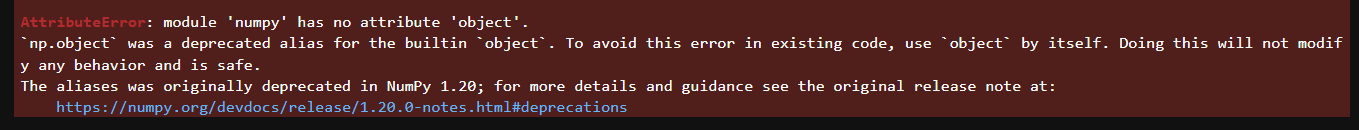

Наверное, можно это как-то решить (как минимум, откатив numpy), но мне лень, поэтому я сделаю просто следующее:

In [1]:
import numpy as np

np.object = object
np.int = int
np.float = float
np.bool = bool

# Предаварительные приготовления

In [2]:
import shutil
import cv2
import pandas as pd
import tensorflow as tf
import os

from PIL import Image
from tqdm.notebook import tqdm, trange
from paths import *
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, UpSampling2D, Activation, MaxPooling2D, Concatenate

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Те самые картинки, на которые я буду лепить здания из найденных датасетов

In [3]:
BACKGROUNDS = os.listdir('backgrounds')
BACKGROUNDS = ['backgrounds/' + a for a in BACKGROUNDS]

Теперь вернёмся к обходу первой проблемы. Несмотря на то, что уникальных цветов действительно много, цвет фона +- всегда одинаковый. А поскольку нам не нужно разбивать здание на составные часть, а нужно лишь отделить здания от того, что зданиями не является, логично с помощью фотошопа узнать цвет фона и не включать фон в маску.

In [4]:
CMP_BACK_COLOR = [(0, 0, 170)]
KG_BACK_COLOR = [(0, 0, 222)]
# В этом датасеты четыре вида фона: небо, дороги, машины/столбы и деревья
TMBUD_BACK_COLOR = [(0, 0, 254), (125, 125, 125), (0, 255, 1), (254, 0, 0)]

# Загрузка данных

Тут тоже не без проблем. Дело в том, что не для всех зданий есть маска, но для каждой маски имеется здание. Поэтому, значала читаем пути к маскам

In [5]:
masks = []
for path in [CMP_MASKS_PATH, KG_MASKS_PATH, TMBUD_MASKS_PATH]:
    for file in os.listdir(path):
        masks.append(f'{path}/{file}')
masks = pd.Series(masks)

А потом читаем пути к зданиям, но только если найдётся соответствующая маска

In [6]:
masks_filenames = masks.apply(lambda x: x.split('/')[-1])
facades = []
for m_path, f_path in [(CMP_MASKS_PATH, CMP_FACADES_PATH), 
                       (KG_MASKS_PATH, KG_FACADES_PATH), 
                       (TMBUD_MASKS_PATH, TMBUD_FACADES_PATH)]:
    for file in os.listdir(m_path):
        if file in masks_filenames.values:
            facades.append(f'{f_path}/{file}')
facades = pd.Series(facades)

In [7]:
data = pd.DataFrame({'fcd': facades, 'msk': masks})

Проверим, что всё действительно так, как мы ожидаем:

In [8]:
if (data.fcd.apply(lambda x: x.replace('_fcds', '_masks')) == data.msk).sum() == len(data):
   print('Всё как надо')
else:
    print('Что-то пошло не так')

Всё как надо


# Необходимые функции

In [9]:
def get_background_mask(mask, back_code):
    '''
    Выделяет на маске здание путём удаления (точнее, "зануления") фона 
    
        mask (np.ndarray) - маска
        back_code (list of tuples) - цвета (цвета) фона (то есть, всего, что НЕ здание)
    '''
    new_mask = (mask == back_code[0]).sum(axis = 2) != 3
    for i in range(1, len(back_code)):
        new_mask = new_mask & ((mask == back_code[i]).sum(axis = 2) != 3)
    return new_mask

        
def combine_background_and_building(back, facade, mask, back_code = CMP_BACK_COLOR):
    '''
    Лепит здание к фону, создавая тем самым вход для обучающей выборки. Затем создают маску в нужном формате (размер 
    совпадает с размером фона, пиксели здания равны 1, остальные 0)
    
        back (np.ndarray) - фон
        facade (np.ndarray) - фото здания
        mask (np.ndarray) - маска здания
        back_code (list of tuples) - цвета (цвета) фона (то есть, всего, что НЕ здание)
    '''
    while back.shape[0] < facade.shape[0] or back.shape[1] < facade.shape[1]:
        facade = cv2.resize(facade, (int(facade.shape[1] * 0.95), int(facade.shape[0] * 0.95)), interpolation = cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (int(mask.shape[1] * 0.95), int(mask.shape[0] * 0.95)), interpolation = cv2.INTER_LINEAR)

    l_up_x = np.random.randint(0, back.shape[0] - facade.shape[0]) if back.shape[0] != facade.shape[0] else 0
    l_up_y = np.random.randint(0, back.shape[1] - facade.shape[1]) if back.shape[1] != facade.shape[1] else 0
    
    new_mask = np.zeros((back.shape[0], back.shape[1]), dtype = int)
    new_mask[l_up_x: l_up_x + mask.shape[0], l_up_y: l_up_y + mask.shape[1]][get_background_mask(mask, back_code)] = 1
    
    back[l_up_x : l_up_x + facade.shape[0], l_up_y : l_up_y + facade.shape[1]] = facade
    
    return new_mask

Генерация батчей

In [10]:
def determine_back_color(path):
    '''
    По пути к файлу определяет цвет(а), которые необходимо игнорировать в маске
    '''
    if 'cmp_' in path:
        return CMP_BACK_COLOR
    if 'kg_' in path:
        return KG_BACK_COLOR
    if 'tmbud_' in path:
        return TMBUD_BACK_COLOR
    return None
    
def batch_generator(data, batch_size, with_tmbud = True, n_pool = 3):
    '''
    Генерирует батчи для обучения. Необходимость в дальнейшем пихать это в tf.data.Dataset.from_generator
    заставляет идти на поводу у этой невероятной технологии от гугл. Во-первых, она почему-то сериализует данную ей таблицу.
    Отсюда необходимость в первой строчке сей функции. Во-вторых, сериализация касается содержимого таблички, так что 
    приходится применять метод decode()
    Далее, поскольку гораздо лучше, чтобы в пределах батча картинки имели всё-таки одинаковые размеры, все картинки
    приводятся к размеру максимальной в батче
    
       data (чёрт пойми что, во что превращает понятную табличку tf.data.Dataset.from_generator) - данные
       batch_size (int) - размер батча
       with_tmbud (bool) - датасет от tmbud, как уже упоминалось, несколько особенный. Так что имеется возможность 
                           обучатся без него
       n_pool (int) - количество MaxPolling слоёв в энкодере
    '''
    data = pd.DataFrame(data, columns = ['fcd', 'msk'])
    if not with_tmbud:
        data = data[~data.fcd.apply(lambda x: x.decode('utf-8')).str.contains('tmbud')]
        
    batch = []
    while len(batch)!= batch_size:
        smp = data.sample()
        fcd_path, mask_path = smp.fcd.values[0].decode('utf-8'), smp.msk.values[0].decode('utf-8')
        if not os.path.isfile(fcd_path) or not os.path.isfile(mask_path):
            continue
            
        fcd, msk = cv2.imread(fcd_path), cv2.imread(mask_path)
        fcd, msk = cv2.cvtColor(fcd, cv2.COLOR_RGB2BGR), cv2.cvtColor(msk, cv2.COLOR_RGB2BGR)
            
        back_code = determine_back_color(fcd_path)
        if back_code is None:
            continue
        
        back_path = np.random.choice(BACKGROUNDS)
        if not os.path.isfile(back_path):
            continue
            
        background = cv2.imread(back_path)
        background = cv2.cvtColor(background, cv2.COLOR_RGB2BGR)
        if background is None:
            continue
        
        if background.shape[0] % 2 ** n_pool != 0 or background.shape[1] % 2 ** n_pool != 0:
            # Обрезаем верхние ряды изображения и его левые столбцы так, чтобы обе размерности делились на 2^n_pool 
            background = background[background.shape[0] % 2**n_pool:, background.shape[1] % 2**n_pool:]

        mask = combine_background_and_building(background, fcd, msk, back_code = back_code)
        if mask is None:
            continue
        
        background, mask = (background / 255).astype(np.float32), mask.astype(np.int8) 
        batch.append((background, mask))
    
    # Приводим все изображения в батче к одному размеру 
    images = [batch[i][0] for i in range(batch_size)]
    max_shape_im = tuple(max(image.shape[x] for image in images) for x in range(3))
    images_batch = np.zeros((batch_size,) + max_shape_im, dtype = 'float32')
    for image_index, image in enumerate(images):
        images_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image
    
    # Аналогично с масками
    masks = [batch[i][1] for i in range(batch_size)]
    max_mask_im = tuple(max(mask.shape[x] for mask in masks) for x in range(2))
    masks_batch = np.zeros((batch_size,) + max_mask_im, dtype = 'float32')
    for mask_index, mask in enumerate(masks):
        masks_batch[mask_index, :mask.shape[0], :mask.shape[1]] = mask
    
    # Выдаём элементы из батча по одному 
    batch = tuple(zip(images_batch, masks_batch[:, :, :, np.newaxis]))
    for i in range(len(batch)):
        yield batch[i][0][np.newaxis, :, :, :], batch[i][1][np.newaxis, :, :, :]

И немного кода для тестирования сети на фотографиях, не учавствовавших в обучении

In [11]:
def test_model(nn, test_path):
    '''
    Для каждой фотографии из test_path выводит саму фотография, выход нейросети nn 
    и бинарную маску (с порогом 0.5)
    
    nn - Нейросеть
    test_path (str) - Путь к фотографиях, на которых сеть будет тестироваться
    '''
    for file in os.listdir(test_path):
        inp = cv2.imread(f'{test_path}/{file}')
        inp = cv2.cvtColor(inp, cv2.COLOR_RGB2BGR)

        mask = nn.predict((inp.reshape((1,) + inp.shape))/255)
        mask = np.array(mask)
        mask = mask.reshape(mask.shape[1:-1])
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 15))

        ax[0].imshow(inp)
        ax[1].imshow(mask)
        
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        ax[2].imshow(mask)                                                                                                                          

# SegNet

In [11]:
_input = tf.keras.layers.Input(shape = (None, None, 3))
# ---------------Encoder--------------
conv_1_1 = Conv2D(16, (3, 3), padding = 'same')(_input)
conv_1_1 = Activation('relu')(conv_1_1)
drout_1_1 = Dropout(0.85)(conv_1_1)

conv_1_2 = Conv2D(16, (3, 3), padding = 'same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
drout_1_2 = Dropout(0.85)(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(32, (3, 3), padding = 'same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
drout_2_1 = Dropout(0.85)(conv_2_1)

conv_2_2 = Conv2D(32, (3, 3), padding = 'same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
drout_2_2 = Dropout(0.85)(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(64, (3, 3), padding = 'same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
drout_3_1 = Dropout(0.85)(conv_3_1)

conv_3_2 = Conv2D(64, (3, 3), padding = 'same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
drout_3_2 = Dropout(0.85)(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(128, (3, 3), padding = 'same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
drout_4_1 = Dropout(0.85)(conv_4_1)

conv_4_2 = Conv2D(128, (3, 3), padding = 'same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
drout_4_2 = Dropout(0.85)(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(256, (3, 3), padding = 'same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
drout_5_1 = Dropout(0.85)(conv_5_1)

conv_5_2 = Conv2D(256, (3, 3), padding = 'same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
drout_5_2 = Dropout(0.85)(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)


# ---------------Decoder--------------

up_1 = UpSampling2D(2, interpolation = 'bilinear')(pool_5)

conv_6_1 = Conv2D(256, (3, 3), padding = 'same')(up_1)
conv_6_1 = Activation('relu')(conv_6_1)
drout_6_1 = Dropout(0.85)(conv_6_1)

conv_6_2 = Conv2D(256, (3, 3), padding = 'same')(conv_6_1)
conv_6_2 = Activation('relu')(conv_6_2)
drout_6_2 = Dropout(0.85)(conv_6_2)

up_2 = UpSampling2D(2, interpolation = 'bilinear')(conv_6_2)

conv_7_1 = Conv2D(128, (3, 3), padding = 'same')(up_2)
conv_7_1 = Activation('relu')(conv_7_1)
drout_7_1 = Dropout(0.85)(conv_7_1)

conv_7_2 = Conv2D(128, (3, 3), padding = 'same')(conv_7_1)
conv_7_2 = Activation('relu')(conv_7_2)
drout_7_2 = Dropout(0.85)(conv_7_2)

up_3 = UpSampling2D(2, interpolation = 'bilinear')(conv_7_2)

conv_8_1 = Conv2D(64, (3, 3), padding = 'same')(up_3)
conv_8_1 = Activation('relu')(conv_8_1)
drout_8_1 = Dropout(0.85)(conv_8_1)

conv_8_2 = Conv2D(64, (3, 3), padding = 'same')(conv_8_1)
conv_8_2 = Activation('relu')(conv_8_2)
drout_8_2 = Dropout(0.85)(conv_8_2)

up_4 = UpSampling2D(2, interpolation = 'bilinear')(conv_8_2)

conv_9_1 = Conv2D(32, (3, 3), padding = 'same')(up_4)
conv_9_1 = Activation('relu')(conv_9_1)
drout_9_1 = Dropout(0.85)(conv_9_1)

conv_9_2 = Conv2D(32, (3, 3), padding = 'same')(conv_9_1)
conv_9_2 = Activation('relu')(conv_9_2)
drout_9_2 = Dropout(0.85)(conv_9_2)

up_5 = UpSampling2D(2, interpolation = 'bilinear')(conv_9_2)

conv_10_1 = Conv2D(16, (3, 3), padding = 'same')(up_5)
conv_10_1 = Activation('relu')(conv_10_1)
drout_10_1 = Dropout(0.85)(conv_10_1)

conv_10_2 = Conv2D(16, (3, 3), padding = 'same')(conv_10_1)
conv_10_2 = Activation('relu')(conv_10_2)
drout_10_2 = Dropout(0.85)(conv_10_2)

result = Conv2D(1, (3, 3), padding = 'same')(conv_10_2)
result = Activation('sigmoid')(result)

segnet_model = Model(inputs = _input, outputs = result)

In [12]:
segnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
activation (Activation)      (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 16)    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640  

In [13]:
import datetime

best_w = tf.keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                                    monitor = 'val_loss',
                                                    verbose = 0,
                                                    save_best_only = True,
                                                    save_weights_only = False,
                                                    mode = 'auto',
                                                    save_freq = 'epoch')

last_w = tf.keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                                     monitor = 'val_loss',
                                                     verbose = 0,
                                                     save_best_only = False,
                                                     save_weights_only = False,
                                                     mode = 'auto',
                                                     save_freq = 'epoch')

val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# После 5-ой эпохи экспоненциально уменьшать learning rate
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.12)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\seg_net\1st_ep{epoch:02d}_v_l_{val_loss:.2f}.hdf5',
                            save_best_only = False)

callbacks = [best_w, 
             last_w, 
             val_loss_callback, 
             lr_callback, 
             tensorboard_callback, 
             model_checkpoint_callback
            ]

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)

segnet_model.compile(optimizer = adam, loss = 'binary_crossentropy')

In [14]:
tf_train = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 150, False, 5),
                                              output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                  tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

tf_val = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 150, False, 5),
                                            output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

In [15]:
segnet_model.fit(tf_train,
                 steps_per_epoch = 300,
                 epochs = 100,
                 verbose = 1,
                 callbacks = callbacks,
                 validation_data = tf_val,
                 validation_steps = 50)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 228s 682ms/step - loss: 0.2770 - val_loss: 0.2238
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 203s 642ms/step - loss: 0.2534 - val_loss: 0.2278
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 206s 654ms/step - loss: 0.2282 - val_loss: 0.2453
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 206s 656ms/step - loss: 0.2391 - val_loss: 0.2513
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 207s 656ms/step - loss: 0.2346 - val_loss: 0.2126
Epoch 6/100

Epoch 00006: LearningRateScheduler setting

In [16]:
# def plot_rand_nn_res(model, thresh):
#     fig, ax = plt.subplots(nrows=1, ncols=2)
#     a = list(batch_generator(data.values.astype(bytes), 1))
#     ax[0].imshow((a[0][0]*255).astype(int).reshape(a[0][0].shape[1:]))
    
#     mask = model.predict(a[0][0])
    
#     mask = np.array(mask)
#     mask = mask.reshape(mask.shape[1:-1])
#     mask = np.where(mask > 0.5, 1, 0)
    
#     ax[1].imshow(mask)
#     return (a[0][0]*255).astype(int).reshape(a[0][0].shape[1:]), mask

In [16]:
segnet_model = tf.keras.models.load_model(r'saved_models/seg_net/1st_ep30_v_l_0.04.hdf5')

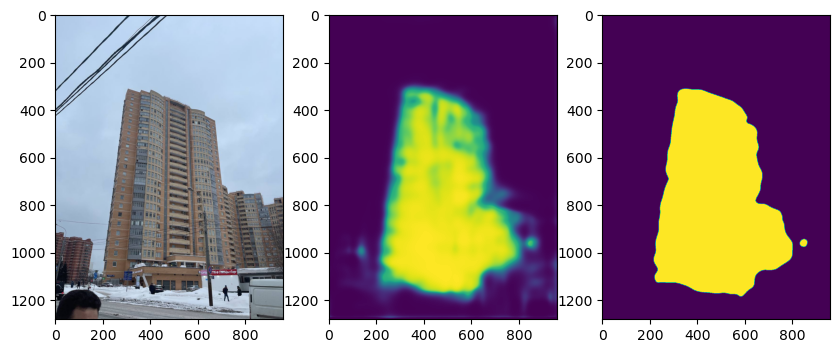

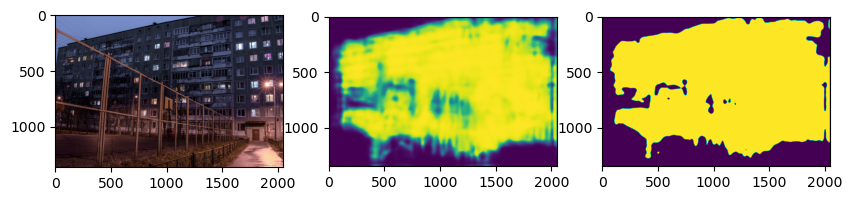

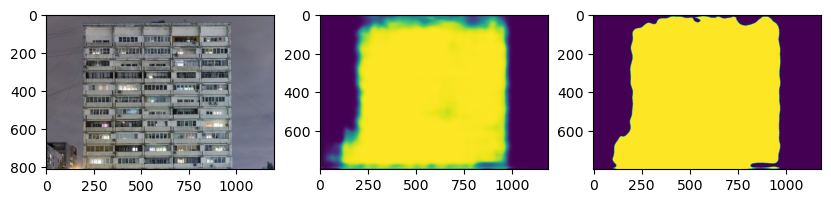

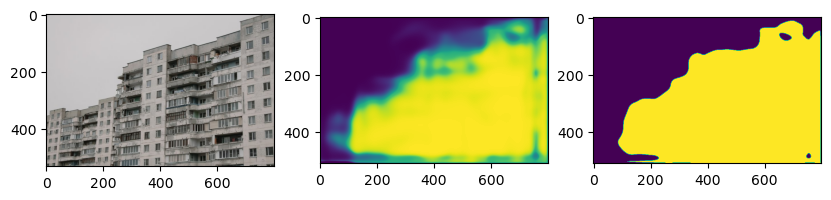

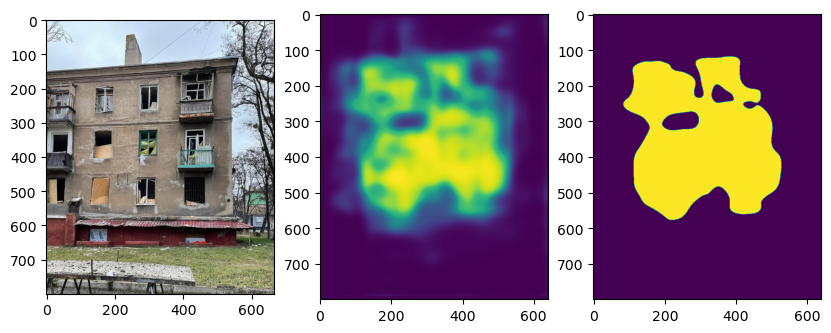

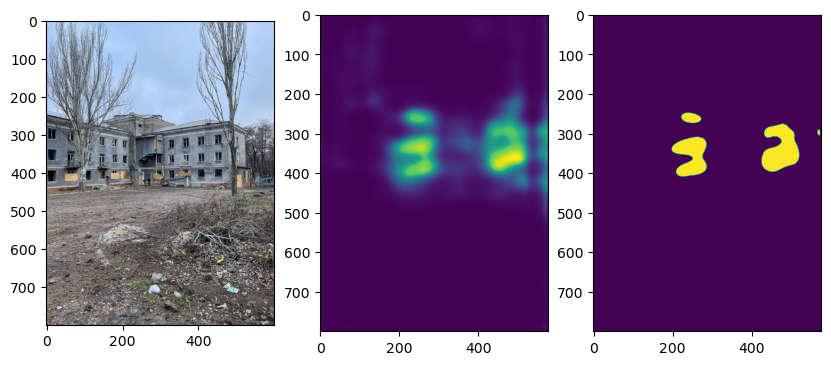

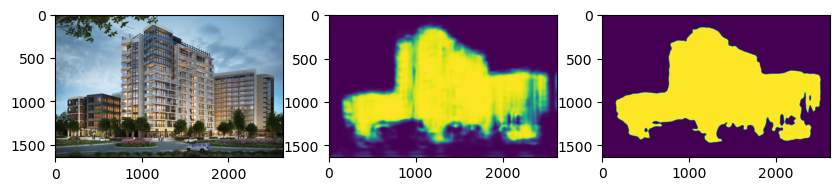

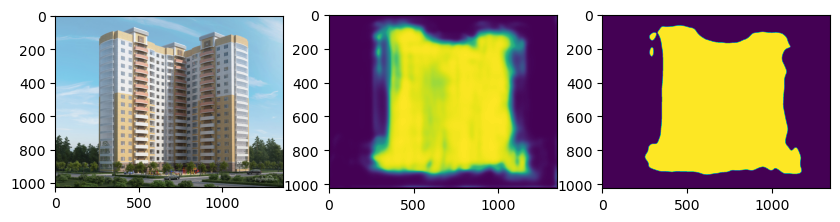

In [19]:
test_model(segnet_model, 'test_data')

Порадовал результат на предпоследней и последней фотографии. На предпоследней просто весьма и весьма хорошо выделено здание (и даже "обогнуты" деревья). Касаемо последней фотографии, понятно почему сеть не пометила края здания. Во-первых, они другого цвета. Во-вторых, на этих торцах здания не особо виднеются окна. Так что не мудрено, что сеть слегка запуталась

# UNet

In [11]:

_input = tf.keras.layers.Input(shape = (None, None, 3))
# ---------------Encoder--------------
conv_1_1 = Conv2D(16, (3, 3), padding = 'same')(_input)
conv_1_1 = Activation('relu')(conv_1_1)
drout_1_1 = Dropout(0.85)(conv_1_1)

conv_1_2 = Conv2D(16, (3, 3), padding = 'same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
drout_1_2 = Dropout(0.85)(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(32, (3, 3), padding = 'same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
drout_2_1 = Dropout(0.85)(conv_2_1)

conv_2_2 = Conv2D(32, (3, 3), padding = 'same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
drout_2_2 = Dropout(0.85)(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(64, (3, 3), padding = 'same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
drout_3_1 = Dropout(0.85)(conv_3_1)

conv_3_2 = Conv2D(64, (3, 3), padding = 'same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
drout_3_2 = Dropout(0.85)(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(128, (3, 3), padding = 'same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
drout_4_1 = Dropout(0.85)(conv_4_1)

conv_4_2 = Conv2D(128, (3, 3), padding = 'same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
drout_4_2 = Dropout(0.85)(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(256, (3, 3), padding = 'same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
drout_5_1 = Dropout(0.85)(conv_5_1)

conv_5_2 = Conv2D(256, (3, 3), padding = 'same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
drout_5_2 = Dropout(0.85)(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)

conv_6_1 = Conv2D(512, (3, 3), padding = 'same')(pool_5)
conv_6_1 = Activation('relu')(conv_6_1)
drout_6_1 = Dropout(0.85)(conv_6_1)

pool_6 = MaxPooling2D(2)(conv_6_1)


# ---------------Decoder--------------


up_1 = UpSampling2D(2, interpolation = 'bilinear')(pool_6)
conc_1 = Concatenate()([conv_6_1, up_1])

conv_7_2 = Conv2D(512, (3, 3), padding = 'same')(conv_6_1)
conv_7_2 = Activation('relu')(conv_7_2)
drout_7_2 = Dropout(0.85)(conv_7_2)

up_2 = UpSampling2D(2, interpolation = 'bilinear')(conv_7_2)
conc_2 = Concatenate()([conv_5_2, up_2])

conv_8_1 = Conv2D(256, (3, 3), padding = 'same')(up_2)
conv_8_1 = Activation('relu')(conv_8_1)
drout_8_1 = Dropout(0.85)(conv_8_1)

conv_8_2 = Conv2D(256, (3, 3), padding = 'same')(conv_8_1)
conv_8_2 = Activation('relu')(conv_8_2)
drout_8_2 = Dropout(0.85)(conv_8_2)

up_3 = UpSampling2D(2, interpolation = 'bilinear')(conv_8_2)
conc_3 = Concatenate()([conv_4_2, up_3])

conv_9_1 = Conv2D(128, (3, 3), padding = 'same')(up_3)
conv_9_1 = Activation('relu')(conv_9_1)
drout_9_1 = Dropout(0.85)(conv_9_1)

conv_9_2 = Conv2D(128, (3, 3), padding = 'same')(conv_9_1)
conv_9_2 = Activation('relu')(conv_9_2)
drout_9_2 = Dropout(0.85)(conv_9_2)

up_4 = UpSampling2D(2, interpolation = 'bilinear')(conv_9_2)
conc_4 = Concatenate()([conv_3_2, up_4])

conv_10_1 = Conv2D(64, (3, 3), padding = 'same')(up_4)
conv_10_1 = Activation('relu')(conv_10_1)
drout_10_1 = Dropout(0.85)(conv_10_1)

conv_10_2 = Conv2D(64, (3, 3), padding = 'same')(conv_10_1)
conv_10_2 = Activation('relu')(conv_10_2)
drout_10_2 = Dropout(0.85)(conv_10_2)

up_5 = UpSampling2D(2, interpolation = 'bilinear')(conv_10_2)
conc_5 = Concatenate()([conv_2_2, up_5])

conv_11_1 = Conv2D(32, (3, 3), padding = 'same')(up_5)
conv_11_1 = Activation('relu')(conv_11_1)
drout_11_1 = Dropout(0.85)(conv_11_1)

conv_11_2 = Conv2D(32, (3, 3), padding = 'same')(conv_11_1)
conv_11_2 = Activation('relu')(conv_11_2)
drout_11_2 = Dropout(0.85)(conv_11_2)

up_6 = UpSampling2D(2, interpolation = 'bilinear')(conv_11_2)
conc_6 = Concatenate()([conv_1_2, up_6])

conv_12_1 = Conv2D(16, (3, 3), padding = 'same')(up_6)
conv_12_1 = Activation('relu')(conv_12_1)
drout_12_1 = Dropout(0.85)(conv_12_1)

conv_12_2 = Conv2D(16, (3, 3), padding = 'same')(conv_12_1)
conv_12_2 = Activation('relu')(conv_12_2)
drout_12_2 = Dropout(0.85)(conv_12_2)

result = Conv2D(1, (3, 3), padding = 'same')(conv_12_2)
result = Activation('sigmoid')(result)

unet_model = Model(inputs = _input, outputs = result)

In [12]:
unet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
activation (Activation)      (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 16)    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640  

In [46]:
import datetime

best_w = tf.keras.callbacks.ModelCheckpoint('unet_best.h5',
                                                    monitor = 'val_loss',
                                                    verbose = 0,
                                                    save_best_only = True,
                                                    save_weights_only = False,
                                                    mode = 'auto',
                                                    save_freq = 'epoch')

last_w = tf.keras.callbacks.ModelCheckpoint('unet_last.h5',
                                                     monitor = 'val_loss',
                                                     verbose = 0,
                                                     save_best_only = False,
                                                     save_weights_only = False,
                                                     mode = 'auto',
                                                     save_freq = 'epoch')

val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# После 5-ой эпохи экспоненциально уменьшать learning rate
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.14)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\unet\1st_ep{epoch:02d}_v_l_{val_loss:.4f}.hdf5',
                            save_best_only = False)

callbacks = [best_w, 
             last_w, 
             val_loss_callback, 
             lr_callback, 
             tensorboard_callback, 
             model_checkpoint_callback
            ]

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)

unet_model.compile(optimizer = adam, loss = 'binary_crossentropy')

In [47]:
tf_train = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 100, False, 6),
                                              output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                  tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

tf_val = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 100, False, 6),
                                            output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

In [48]:
unet_model.fit(tf_train,
               steps_per_epoch = 300,
               epochs = 100,
               verbose = 1,
               callbacks = callbacks,
               validation_data = tf_val,
               validation_steps = 50)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 288s 858ms/step - loss: 0.2804 - val_loss: 0.2358
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 219s 696ms/step - loss: 0.2224 - val_loss: 0.3163
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 227s 730ms/step - loss: 0.2110 - val_loss: 0.2414
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 241s 772ms/step - loss: 0.2065 - val_loss: 0.2173
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 245s 784ms/step - loss: 0.2044 - val_loss: 0.1907
Epoch 6/100

Epoch 00006: LearningRateScheduler setting

In [12]:
unet_model = tf.keras.models.load_model(r'saved_models/unet/1st_ep27_v_l_0.0622.hdf5')

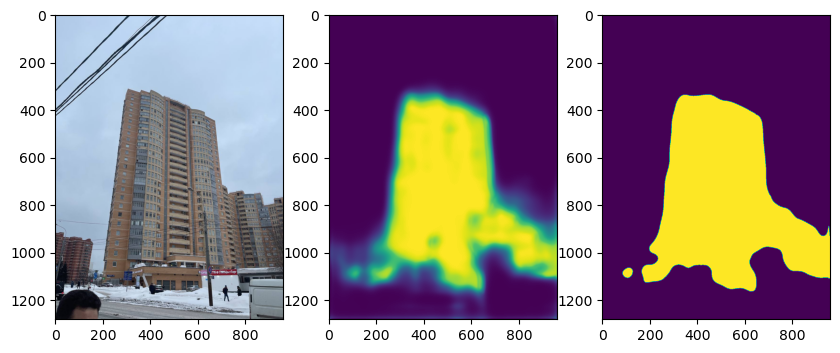

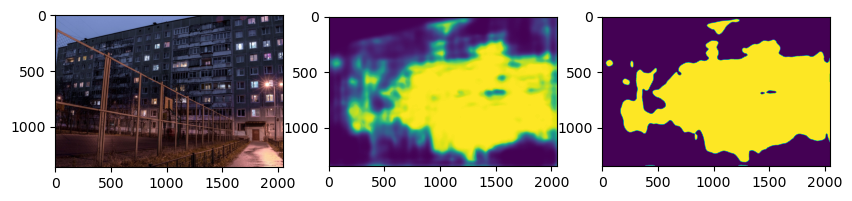

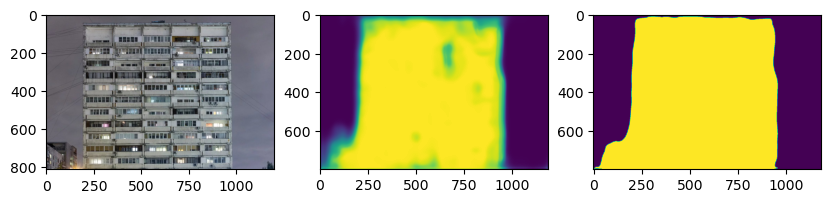

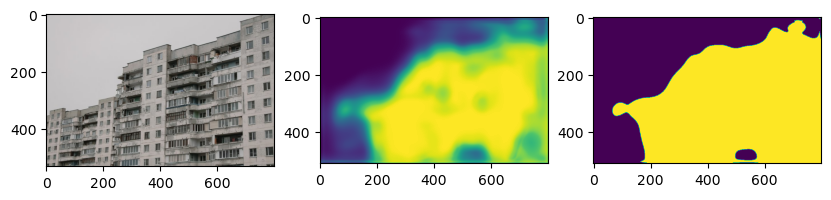

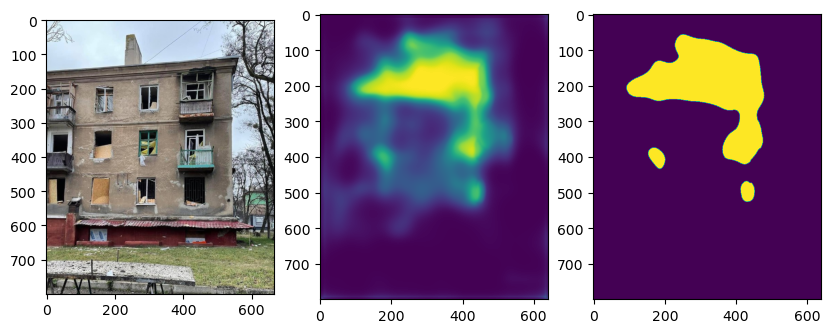

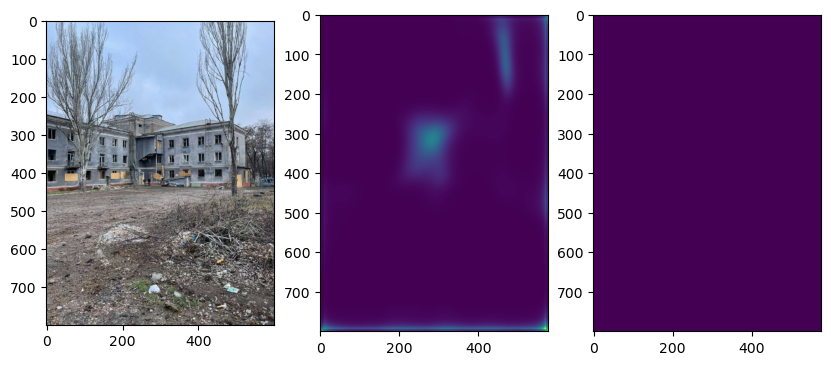

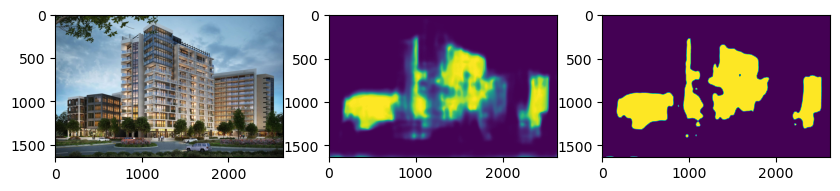

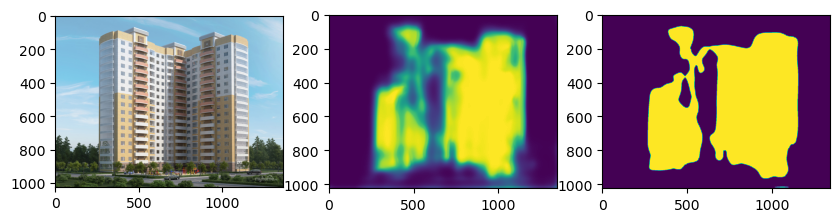

In [13]:
test_model(unet_model, 'test_data')

Где-то стало лучше, где-то хуже. С первой фотографией вроде бы вышло поприятнее. Чего нельзя сказать о двух последних. В остальном, всё не лучше, чем у прошлой сети. Я бы даже сказал хуже. Вообще, появляется подозрение, что имеет место переобучение, так что попробуем эту же архитектуру, но с меньшим количество слоёв.

# Unet полегче

In [11]:

_input = tf.keras.layers.Input(shape = (None, None, 3))
# ---------------Encoder--------------
conv_1_1 = Conv2D(16, (3, 3), padding = 'same')(_input)
conv_1_1 = Activation('relu')(conv_1_1)
drout_1_1 = Dropout(0.85)(conv_1_1)

conv_1_2 = Conv2D(16, (3, 3), padding = 'same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
drout_1_2 = Dropout(0.85)(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(32, (3, 3), padding = 'same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
drout_2_1 = Dropout(0.85)(conv_2_1)

conv_2_2 = Conv2D(32, (3, 3), padding = 'same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
drout_2_2 = Dropout(0.85)(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(64, (3, 3), padding = 'same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
drout_3_1 = Dropout(0.85)(conv_3_1)

conv_3_2 = Conv2D(64, (3, 3), padding = 'same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
drout_3_2 = Dropout(0.85)(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(128, (3, 3), padding = 'same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
drout_4_1 = Dropout(0.85)(conv_4_1)

conv_4_2 = Conv2D(128, (3, 3), padding = 'same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
drout_4_2 = Dropout(0.85)(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(256, (3, 3), padding = 'same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
drout_5_1 = Dropout(0.85)(conv_5_1)

conv_5_2 = Conv2D(256, (3, 3), padding = 'same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
drout_5_2 = Dropout(0.85)(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)


# ---------------Decoder--------------


up_2 = UpSampling2D(2, interpolation = 'bilinear')(pool_5)
conc_2 = Concatenate()([conv_5_2, up_2])

conv_8_1 = Conv2D(256, (3, 3), padding = 'same')(up_2)
conv_8_1 = Activation('relu')(conv_8_1)
drout_8_1 = Dropout(0.85)(conv_8_1)

conv_8_2 = Conv2D(256, (3, 3), padding = 'same')(conv_8_1)
conv_8_2 = Activation('relu')(conv_8_2)
drout_8_2 = Dropout(0.85)(conv_8_2)

up_3 = UpSampling2D(2, interpolation = 'bilinear')(conv_8_2)
conc_3 = Concatenate()([conv_4_2, up_3])

conv_9_1 = Conv2D(128, (3, 3), padding = 'same')(up_3)
conv_9_1 = Activation('relu')(conv_9_1)
drout_9_1 = Dropout(0.85)(conv_9_1)

conv_9_2 = Conv2D(128, (3, 3), padding = 'same')(conv_9_1)
conv_9_2 = Activation('relu')(conv_9_2)
drout_9_2 = Dropout(0.85)(conv_9_2)

up_4 = UpSampling2D(2, interpolation = 'bilinear')(conv_9_2)
conc_4 = Concatenate()([conv_3_2, up_4])

conv_10_1 = Conv2D(64, (3, 3), padding = 'same')(up_4)
conv_10_1 = Activation('relu')(conv_10_1)
drout_10_1 = Dropout(0.85)(conv_10_1)

conv_10_2 = Conv2D(64, (3, 3), padding = 'same')(conv_10_1)
conv_10_2 = Activation('relu')(conv_10_2)
drout_10_2 = Dropout(0.85)(conv_10_2)

up_5 = UpSampling2D(2, interpolation = 'bilinear')(conv_10_2)
conc_5 = Concatenate()([conv_2_2, up_5])

conv_11_1 = Conv2D(32, (3, 3), padding = 'same')(up_5)
conv_11_1 = Activation('relu')(conv_11_1)
drout_11_1 = Dropout(0.85)(conv_11_1)

conv_11_2 = Conv2D(32, (3, 3), padding = 'same')(conv_11_1)
conv_11_2 = Activation('relu')(conv_11_2)
drout_11_2 = Dropout(0.85)(conv_11_2)

up_6 = UpSampling2D(2, interpolation = 'bilinear')(conv_11_2)
conc_6 = Concatenate()([conv_1_2, up_6])

conv_12_1 = Conv2D(16, (3, 3), padding = 'same')(up_6)
conv_12_1 = Activation('relu')(conv_12_1)
drout_12_1 = Dropout(0.85)(conv_12_1)

conv_12_2 = Conv2D(16, (3, 3), padding = 'same')(conv_12_1)
conv_12_2 = Activation('relu')(conv_12_2)
drout_12_2 = Dropout(0.85)(conv_12_2)

result = Conv2D(1, (3, 3), padding = 'same')(conv_12_2)
result = Activation('sigmoid')(result)

unet_light = Model(inputs = _input, outputs = result)

Получилась нейросеть по количеству параметров близкая к первой.

In [12]:
unet_light.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
activation (Activation)      (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 16)    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    4640  

In [13]:
import datetime

best_w = tf.keras.callbacks.ModelCheckpoint('unet_best.h5',
                                                    monitor = 'val_loss',
                                                    verbose = 0,
                                                    save_best_only = True,
                                                    save_weights_only = False,
                                                    mode = 'auto',
                                                    save_freq = 'epoch')

last_w = tf.keras.callbacks.ModelCheckpoint('unet_last.h5',
                                                     monitor = 'val_loss',
                                                     verbose = 0,
                                                     save_best_only = False,
                                                     save_weights_only = False,
                                                     mode = 'auto',
                                                     save_freq = 'epoch')

val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# После 5-ой эпохи экспоненциально уменьшать learning rate
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.14)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

# Сохранять модель после каждой эпохи
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\unet_light\1st_ep{epoch:02d}_v_l_{val_loss:.4f}.hdf5',
                            save_best_only = False)

callbacks = [best_w, 
             last_w, 
             val_loss_callback, 
             lr_callback, 
             tensorboard_callback, 
             model_checkpoint_callback
            ]

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)

unet_light.compile(optimizer = adam, loss = 'binary_crossentropy')

In [14]:
tf_train = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 100, False, 5),
                                              output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                  tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

tf_val = tf.data.Dataset.from_generator(batch_generator, args = (data.values, 100, False, 5),
                                            output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                                                                tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.int8))).repeat()

In [15]:
unet_light.fit(tf_train,
               steps_per_epoch = 300,
               epochs = 100,
               verbose = 1,
               callbacks = callbacks,
               validation_data = tf_val,
               validation_steps = 50)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 301s 706ms/step - loss: 0.2646 - val_loss: 0.2194
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 206s 660ms/step - loss: 0.2449 - val_loss: 0.2470
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 214s 681ms/step - loss: 0.2166 - val_loss: 0.2257
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 206s 653ms/step - loss: 0.2160 - val_loss: 0.2028
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0005000000237487257.
300/300 [==============================] - 214s 633ms/step - loss: 0.2302 - val_loss: 0.2546
Epoch 6/100

Epoch 00006: LearningRateScheduler setting

In [14]:
unet_light_model =  tf.keras.models.load_model(r'saved_models/unet_light/1st_ep26_v_l_0.0404.hdf5')

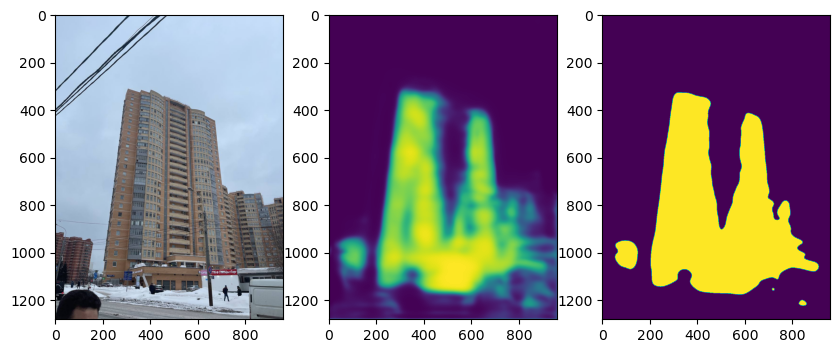

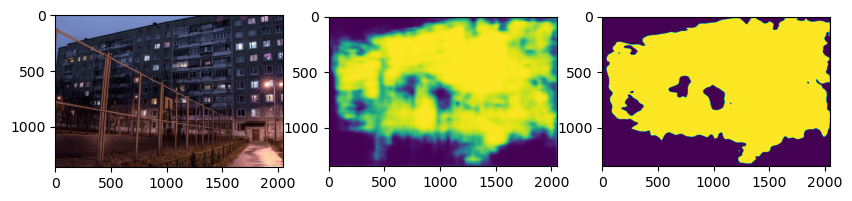

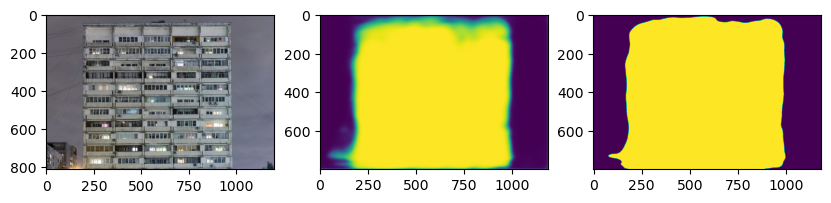

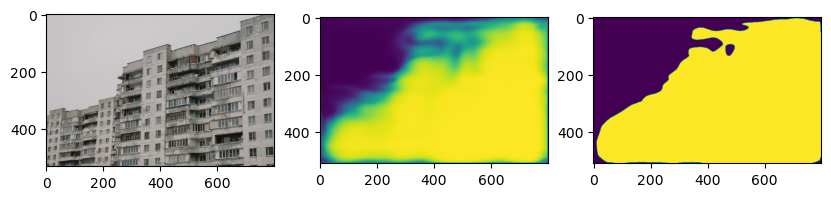

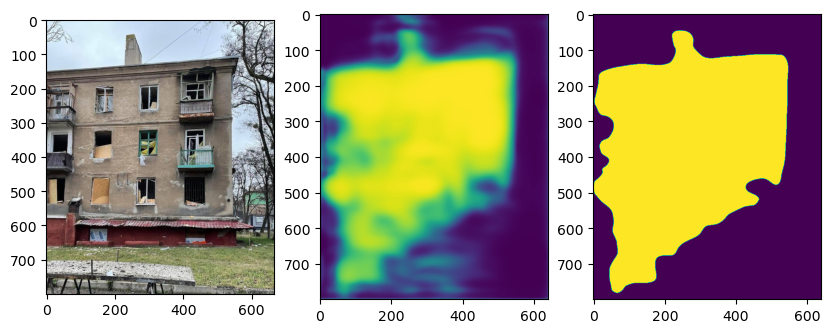

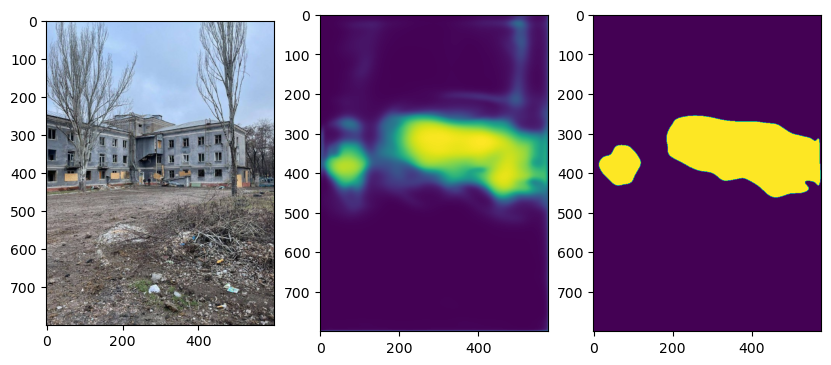

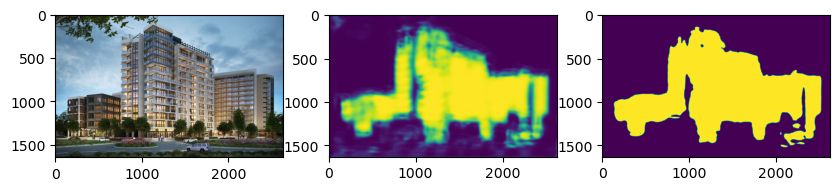

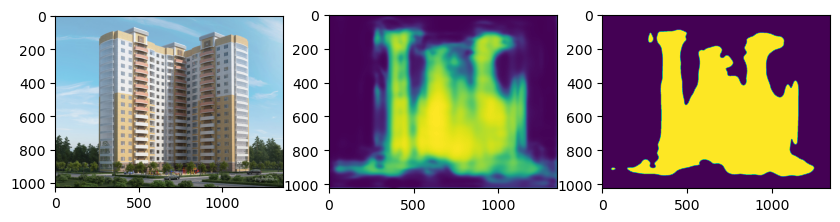

In [15]:
test_model(unet_light_model, 'test_data')

Сразу хочется отметить, что раздолбанное здание на пятой фотографии текущая сеть, в отличии от предыдущих, хотя бы заметила здание, что хорошо. В остальном, ничего хорошего

# Немного мыслей в заключение

Вторая фотография дала понять, что всем представленным сетям сложновато разглядеть здание, когда на улице темно. Подталкивает к мысли попробовать аугментировать изображения (и, в частности, изменять яркость изображения). Однако разного рода аугментации (реализованные с помощью albumentations) не привели к чему бы то ни было толковому. Пробовались и радикальные аугментации с сжатием, пережатием, сдвигами, поворотами (и пару раз даже с какими-то деформациями, о которых я даже не понимаю что они делают :D), и небольшие аугментации (например, небольшой сдвиг + изменение яркости, сдвиг + поворот и т.д

Однако с учётом того, что качество входных данных оставляет желать лучшего, итоговым результатом я в целом доволен